# Deep Convolutional GANs

In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored last year and has seen impressive results in generating new images, you can read the [original paper here](https://arxiv.org/pdf/1511.06434.pdf).

You'll be training DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

![SVHN Examples](assets/SVHN_examples.png)

So, we'll need a deeper and more powerful network. This is accomplished through using convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get the convolutional networks to train. The only real changes compared to what [you saw previously](https://github.com/udacity/deep-learning/tree/master/gan_mnist) are in the generator and discriminator, otherwise the rest of the implementation is the same.

In [1]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

In [2]:
!mkdir data

A subdirectory or file data already exists.


## Getting the data

Here you can download the SVHN dataset. Run the cell above and it'll download to your machine.

In [3]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Testing Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

SVHN Training Set: 182MB [00:15, 11.8MB/s]                                                                             
SVHN Testing Set: 64.3MB [00:05, 11.6MB/s]                                                                             


These SVHN files are `.mat` files typically used with Matlab. However, we can load them in with `scipy.io.loadmat` which we imported above.

In [4]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real images we'll pass to the discriminator and what the generator will eventually fake.

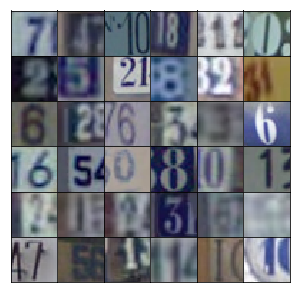

In [5]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

Here we need to do a bit of preprocessing and getting the images into a form where we can pass batches to the network. First off, we need to rescale the images to a range of -1 to 1, since the output of our generator is also in that range. We also have a set of test and validation images which could be used if we're trying to identify the numbers in the images.

In [6]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [7]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(dataset.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), y

## Network Inputs

Here, just creating some placeholders like normal.

In [8]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

## Generator

Here you'll build the generator network. The input will be our noise vector `z` as before. Also as before, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.

What's new here is we'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically you'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

You keep stacking layers up like this until you get the final transposed convolution layer with shape 32x32x3. Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](assets/dcgan.png)

Note that the final layer here is 64x64x3, while for our SVHN dataset, we only want it to be 32x32x3. 

>**Exercise:** Build the transposed convolutional network for the generator in the function below. Be sure to use leaky ReLUs on all the layers except for the last tanh layer, as well as batch normalization on all the transposed convolutional layers except the last one.

In [12]:
def batch_normalize_lrelu(x, alpha, training=True):
    x = tf.layers.batch_normalization(x, training=training)
    x = tf.maximum(alpha * x, x)
    return x

def generator_input_layer(z, filters, kernel_size, alpha=0.2, training=True):    
    unit_count = kernel_size * kernel_size * filters
    x = tf.layers.dense(z, unit_count)
    x = tf.reshape(x, (-1, kernel_size, kernel_size, filters))
    x = batch_normalize_lrelu(x, alpha, training)
    return x

def generator_conv2d_transpose(x, filters, kernel_size, alpha=0.2, training=True):
    x = tf.layers.conv2d_transpose(x, filters, kernel_size, strides=2, padding='same')
    x = batch_normalize_lrelu(x, alpha, training)
    return x

def discriminator_conv2d(x, filters, kernel_size, alpha=0.2, training=True):
    x = tf.layers.conv2d(x, filters, kernel_size, strides=2, padding='same')
    x = batch_normalize_lrelu(x, alpha, training)
    return x

In [37]:
generator_name = 'generator'
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope(generator_name, reuse=reuse):
        # First fully connected layer
        x = generator_input_layer(z, 512, 4, alpha=alpha, training=training)
        # Shape is now 4x4x512
        
        # Convolutional layers
        x = generator_conv2d_transpose(x, 512, 5, alpha=alpha, training=training)
        # Shape is now 8x8x256 
        x = generator_conv2d_transpose(x, 256, 5, alpha=alpha, training=training)
        # Shape is now 16x16x128
       
        # Output layer, 32x32x3
        logits = tf.layers.conv2d_transpose(x, output_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
        return out

## Discriminator

Here you'll build the discriminator. This is basically just a convolutional classifier like you've built before. The input to the discriminator are 32x32x3 tensors/images. You'll want a few convolutional layers, then a fully connected layer for the output. As before, we want a sigmoid output, and you'll need to return the logits as well. For the depths of the convolutional layers I suggest starting with 16, 32, 64 filters in the first layer, then double the depth as you add layers. Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

You'll also want to use batch normalization with `tf.layers.batch_normalization` on each layer except the first convolutional and output layers. Again, each layer should look something like convolution > batch norm > leaky ReLU.

Note: in this project, your batch normalization layers will always use batch statistics. (That is, always set `training` to `True`.) That's because we are only interested in using the discriminator to help train the generator. However, if you wanted to use the discriminator for inference later, then you would need to set the `training` parameter appropriately.

>**Exercise:** Build the convolutional network for the discriminator. The input is a 32x32x3 images, the output is a sigmoid plus the logits. Again, use Leaky ReLU activations and batch normalization on all the layers except the first.

In [40]:
def discriminator(x, reuse=False, alpha=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x = discriminator_conv2d(x, 32, 5, alpha=alpha)
        # Shape now 16x16x32
        x = discriminator_conv2d(x, 64, 5, alpha=alpha)       
        # Shape now 8x8x64
        x = discriminator_conv2d(x, 128, 5, alpha=alpha)
        # Shape now 4x4x128
        
        flat = tf.reshape(x, (-1, 4*4*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

## Model Loss

Calculating the loss like before, nothing new here.

In [41]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

## Optimizers

Not much new here, but notice how the train operations are wrapped in a `with tf.control_dependencies` block so the batch normalization layers can update their population statistics.

In [42]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

## Building the model

Here we can use the functions we defined about to build the model as a class. This will make it easier to move the network around in our code since the nodes and operations in the graph are packaged in one object.

In [43]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[2], alpha=0.2)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

Here is a function for displaying generated images.

In [44]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

And another function we can use to train our network. Notice when we call `generator` to create the samples to display, we set `training` to `False`. That's so the batch normalization layers will use the population statistics rather than the batch statistics. Also notice that we set the `net.input_real` placeholder when we run the generator's optimizer. The generator doesn't actually use it, but we'd get an error without it because of the `tf.control_dependencies` block we created in `model_opt`. 

In [45]:
def train(net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x, y in dataset.batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, 3, reuse=True, training=False),
                                   feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

## Hyperparameters

GANs are very sensitive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

>**Exercise:** Find hyperparameters to train this GAN. The values found in the DCGAN paper work well, or you can experiment on your own. In general, you want the discriminator loss to be around 0.3, this means it is correctly classifying images as fake or real about 50% of the time.

In [48]:
real_size = (32,32,3)
z_size = 100
learning_rate = 0.0002
batch_size = 128
epochs = 25
alpha = 0.2
beta1 = 0.5

# Create the network
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

Epoch 1/5... Discriminator Loss: 5.9506... Generator Loss: 0.0061
Epoch 1/5... Discriminator Loss: 4.9743... Generator Loss: 0.0225
Epoch 1/5... Discriminator Loss: 3.2741... Generator Loss: 0.1315
Epoch 1/5... Discriminator Loss: 2.9064... Generator Loss: 0.1934
Epoch 1/5... Discriminator Loss: 1.5998... Generator Loss: 0.7633
Epoch 1/5... Discriminator Loss: 1.3266... Generator Loss: 0.7390
Epoch 1/5... Discriminator Loss: 1.5291... Generator Loss: 0.6198
Epoch 1/5... Discriminator Loss: 1.3884... Generator Loss: 0.7539
Epoch 1/5... Discriminator Loss: 1.2127... Generator Loss: 0.8472
Epoch 1/5... Discriminator Loss: 1.0157... Generator Loss: 1.2211


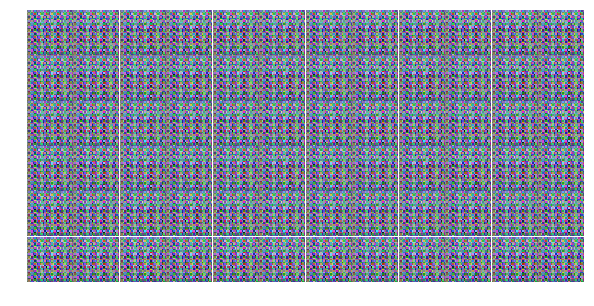

Epoch 1/5... Discriminator Loss: 0.7120... Generator Loss: 1.2928
Epoch 1/5... Discriminator Loss: 0.7608... Generator Loss: 1.4711
Epoch 1/5... Discriminator Loss: 0.7765... Generator Loss: 1.2179
Epoch 1/5... Discriminator Loss: 1.0820... Generator Loss: 1.1573
Epoch 1/5... Discriminator Loss: 1.1503... Generator Loss: 1.3234
Epoch 1/5... Discriminator Loss: 0.9543... Generator Loss: 1.1295
Epoch 1/5... Discriminator Loss: 0.7161... Generator Loss: 1.3773
Epoch 1/5... Discriminator Loss: 0.5316... Generator Loss: 1.5072
Epoch 1/5... Discriminator Loss: 0.6514... Generator Loss: 1.4546
Epoch 1/5... Discriminator Loss: 0.6638... Generator Loss: 1.1910


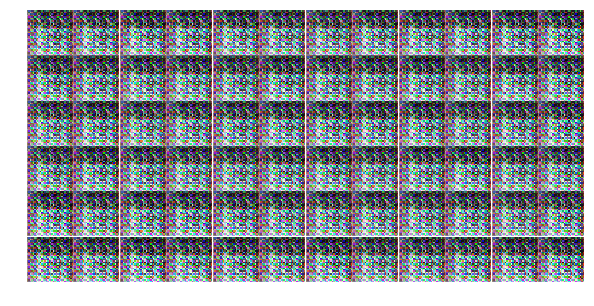

Epoch 1/5... Discriminator Loss: 0.5625... Generator Loss: 1.4547
Epoch 1/5... Discriminator Loss: 0.7028... Generator Loss: 1.5263
Epoch 1/5... Discriminator Loss: 0.5489... Generator Loss: 1.6624
Epoch 1/5... Discriminator Loss: 0.3636... Generator Loss: 1.7883
Epoch 1/5... Discriminator Loss: 0.5463... Generator Loss: 1.3996
Epoch 1/5... Discriminator Loss: 0.5312... Generator Loss: 1.6742
Epoch 1/5... Discriminator Loss: 0.4046... Generator Loss: 1.7230
Epoch 1/5... Discriminator Loss: 0.2710... Generator Loss: 2.0254
Epoch 1/5... Discriminator Loss: 0.2952... Generator Loss: 2.4760
Epoch 1/5... Discriminator Loss: 0.3079... Generator Loss: 2.0222


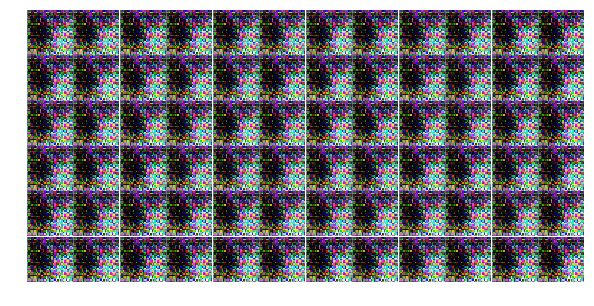

Epoch 1/5... Discriminator Loss: 0.2847... Generator Loss: 2.3175
Epoch 1/5... Discriminator Loss: 0.2420... Generator Loss: 2.0630
Epoch 1/5... Discriminator Loss: 0.5152... Generator Loss: 1.4952
Epoch 1/5... Discriminator Loss: 1.4377... Generator Loss: 0.7016
Epoch 1/5... Discriminator Loss: 2.0213... Generator Loss: 0.5700
Epoch 1/5... Discriminator Loss: 1.6138... Generator Loss: 0.6818
Epoch 1/5... Discriminator Loss: 1.5360... Generator Loss: 0.7984
Epoch 1/5... Discriminator Loss: 1.6002... Generator Loss: 0.6471
Epoch 1/5... Discriminator Loss: 1.3239... Generator Loss: 0.7729
Epoch 1/5... Discriminator Loss: 1.4474... Generator Loss: 0.6788


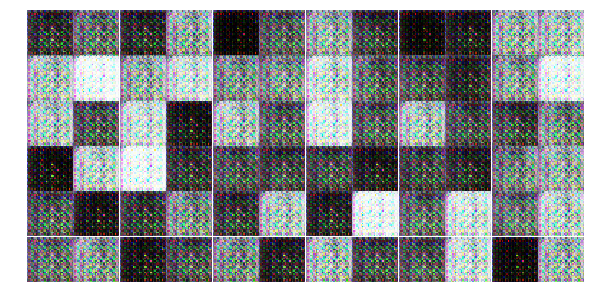

Epoch 1/5... Discriminator Loss: 1.1298... Generator Loss: 0.8151
Epoch 1/5... Discriminator Loss: 0.8438... Generator Loss: 1.2585
Epoch 1/5... Discriminator Loss: 0.9166... Generator Loss: 1.1946
Epoch 1/5... Discriminator Loss: 0.7227... Generator Loss: 1.3064
Epoch 1/5... Discriminator Loss: 0.7486... Generator Loss: 1.3089
Epoch 1/5... Discriminator Loss: 0.6420... Generator Loss: 1.3309
Epoch 1/5... Discriminator Loss: 0.9391... Generator Loss: 0.8320
Epoch 1/5... Discriminator Loss: 0.8427... Generator Loss: 1.1061
Epoch 1/5... Discriminator Loss: 0.7247... Generator Loss: 1.8979
Epoch 1/5... Discriminator Loss: 0.9844... Generator Loss: 0.7666


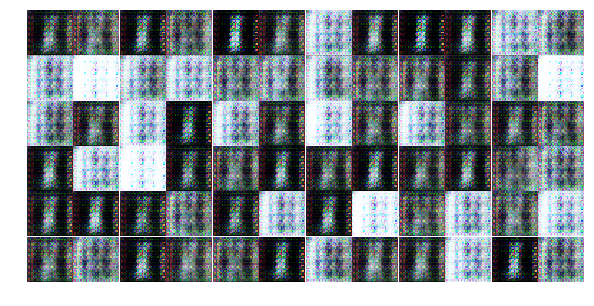

Epoch 1/5... Discriminator Loss: 0.7798... Generator Loss: 1.5964
Epoch 1/5... Discriminator Loss: 0.7145... Generator Loss: 1.1775
Epoch 1/5... Discriminator Loss: 0.8977... Generator Loss: 1.7984
Epoch 1/5... Discriminator Loss: 1.0431... Generator Loss: 0.9248
Epoch 1/5... Discriminator Loss: 0.6395... Generator Loss: 1.4408
Epoch 1/5... Discriminator Loss: 1.1849... Generator Loss: 1.4566
Epoch 1/5... Discriminator Loss: 0.8121... Generator Loss: 0.9080
Epoch 2/5... Discriminator Loss: 0.5843... Generator Loss: 1.7636
Epoch 2/5... Discriminator Loss: 1.0878... Generator Loss: 0.6964
Epoch 2/5... Discriminator Loss: 0.5045... Generator Loss: 1.4662


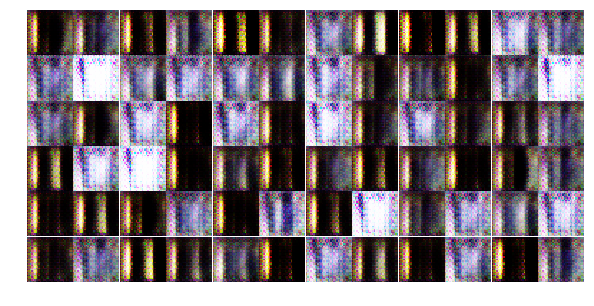

Epoch 2/5... Discriminator Loss: 0.5130... Generator Loss: 3.0652
Epoch 2/5... Discriminator Loss: 0.5138... Generator Loss: 1.9262
Epoch 2/5... Discriminator Loss: 0.6604... Generator Loss: 1.0247
Epoch 2/5... Discriminator Loss: 0.7449... Generator Loss: 0.9714
Epoch 2/5... Discriminator Loss: 0.5700... Generator Loss: 2.2719
Epoch 2/5... Discriminator Loss: 0.5661... Generator Loss: 2.1193
Epoch 2/5... Discriminator Loss: 0.2716... Generator Loss: 2.8282
Epoch 2/5... Discriminator Loss: 1.3433... Generator Loss: 1.8176
Epoch 2/5... Discriminator Loss: 1.3947... Generator Loss: 0.4298
Epoch 2/5... Discriminator Loss: 0.8930... Generator Loss: 1.7259


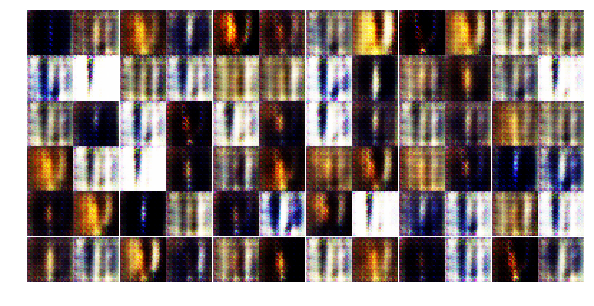

Epoch 2/5... Discriminator Loss: 0.9187... Generator Loss: 0.7427
Epoch 2/5... Discriminator Loss: 0.8631... Generator Loss: 1.0545
Epoch 2/5... Discriminator Loss: 0.5020... Generator Loss: 2.2222
Epoch 2/5... Discriminator Loss: 0.6883... Generator Loss: 1.8032
Epoch 2/5... Discriminator Loss: 0.8219... Generator Loss: 1.1904
Epoch 2/5... Discriminator Loss: 0.3930... Generator Loss: 2.3373
Epoch 2/5... Discriminator Loss: 0.8605... Generator Loss: 0.9092
Epoch 2/5... Discriminator Loss: 0.6941... Generator Loss: 2.1061
Epoch 2/5... Discriminator Loss: 0.4530... Generator Loss: 2.0575
Epoch 2/5... Discriminator Loss: 0.5405... Generator Loss: 1.2572


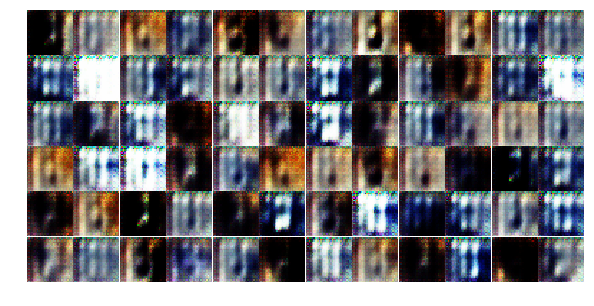

Epoch 2/5... Discriminator Loss: 0.2813... Generator Loss: 2.6590
Epoch 2/5... Discriminator Loss: 0.3619... Generator Loss: 2.6566
Epoch 2/5... Discriminator Loss: 0.2740... Generator Loss: 2.4549
Epoch 2/5... Discriminator Loss: 1.0079... Generator Loss: 0.8249
Epoch 2/5... Discriminator Loss: 0.8728... Generator Loss: 0.8381
Epoch 2/5... Discriminator Loss: 0.6144... Generator Loss: 1.3033
Epoch 2/5... Discriminator Loss: 0.7647... Generator Loss: 2.0628
Epoch 2/5... Discriminator Loss: 0.3441... Generator Loss: 1.8016
Epoch 2/5... Discriminator Loss: 0.1557... Generator Loss: 4.0324
Epoch 2/5... Discriminator Loss: 1.5856... Generator Loss: 0.5436


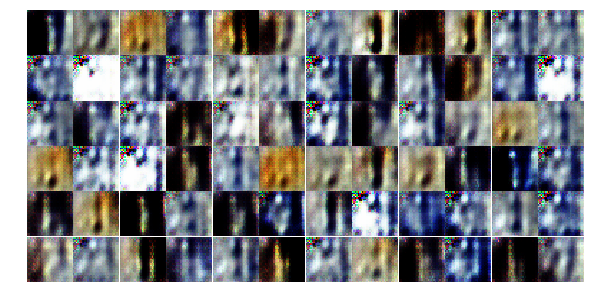

Epoch 2/5... Discriminator Loss: 0.4641... Generator Loss: 1.4247
Epoch 2/5... Discriminator Loss: 0.6155... Generator Loss: 4.4679
Epoch 2/5... Discriminator Loss: 0.3523... Generator Loss: 2.6384
Epoch 2/5... Discriminator Loss: 1.6180... Generator Loss: 0.3213
Epoch 2/5... Discriminator Loss: 0.6119... Generator Loss: 1.3753
Epoch 2/5... Discriminator Loss: 0.8816... Generator Loss: 0.7790
Epoch 2/5... Discriminator Loss: 0.9974... Generator Loss: 2.3176
Epoch 2/5... Discriminator Loss: 0.6068... Generator Loss: 2.4062
Epoch 2/5... Discriminator Loss: 0.7673... Generator Loss: 1.4474
Epoch 2/5... Discriminator Loss: 0.5571... Generator Loss: 1.7009


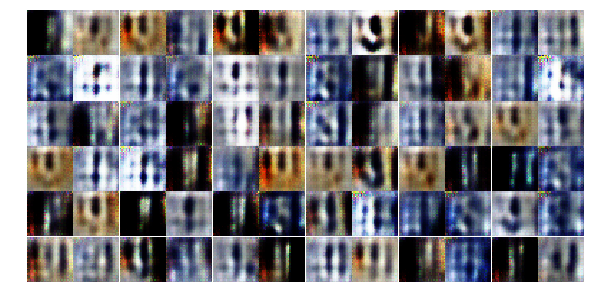

Epoch 2/5... Discriminator Loss: 0.4812... Generator Loss: 2.4713
Epoch 2/5... Discriminator Loss: 0.7002... Generator Loss: 2.6925
Epoch 2/5... Discriminator Loss: 0.6112... Generator Loss: 0.9654
Epoch 2/5... Discriminator Loss: 1.7644... Generator Loss: 0.2770
Epoch 2/5... Discriminator Loss: 1.3640... Generator Loss: 0.4103
Epoch 2/5... Discriminator Loss: 1.1348... Generator Loss: 0.5824
Epoch 2/5... Discriminator Loss: 0.3741... Generator Loss: 2.7375
Epoch 2/5... Discriminator Loss: 0.4485... Generator Loss: 2.2495
Epoch 2/5... Discriminator Loss: 0.5678... Generator Loss: 2.5517
Epoch 2/5... Discriminator Loss: 0.6936... Generator Loss: 1.3089


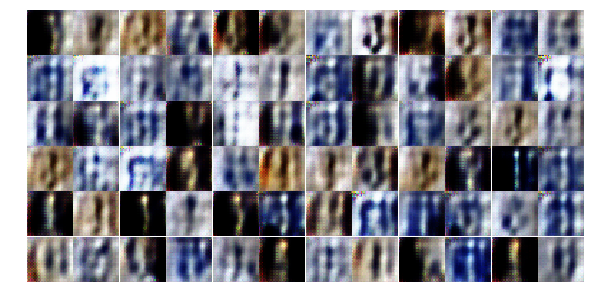

Epoch 2/5... Discriminator Loss: 0.6917... Generator Loss: 1.2871
Epoch 2/5... Discriminator Loss: 0.6257... Generator Loss: 1.1733
Epoch 2/5... Discriminator Loss: 0.9003... Generator Loss: 0.8015
Epoch 2/5... Discriminator Loss: 0.8455... Generator Loss: 0.8222
Epoch 3/5... Discriminator Loss: 0.9387... Generator Loss: 2.8480
Epoch 3/5... Discriminator Loss: 0.8305... Generator Loss: 1.7218
Epoch 3/5... Discriminator Loss: 0.4279... Generator Loss: 2.8561
Epoch 3/5... Discriminator Loss: 0.7589... Generator Loss: 0.8489
Epoch 3/5... Discriminator Loss: 0.7142... Generator Loss: 1.4836
Epoch 3/5... Discriminator Loss: 1.1384... Generator Loss: 0.7840


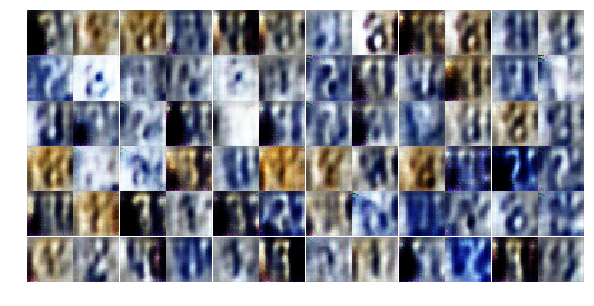

Epoch 3/5... Discriminator Loss: 0.5085... Generator Loss: 1.4908
Epoch 3/5... Discriminator Loss: 0.5511... Generator Loss: 1.2860
Epoch 3/5... Discriminator Loss: 0.7292... Generator Loss: 1.6107
Epoch 3/5... Discriminator Loss: 0.8745... Generator Loss: 0.9578
Epoch 3/5... Discriminator Loss: 1.1239... Generator Loss: 0.5896
Epoch 3/5... Discriminator Loss: 0.6266... Generator Loss: 1.1668
Epoch 3/5... Discriminator Loss: 0.7925... Generator Loss: 1.2168
Epoch 3/5... Discriminator Loss: 0.6435... Generator Loss: 1.3707
Epoch 3/5... Discriminator Loss: 1.0489... Generator Loss: 2.0599
Epoch 3/5... Discriminator Loss: 0.4534... Generator Loss: 2.3688


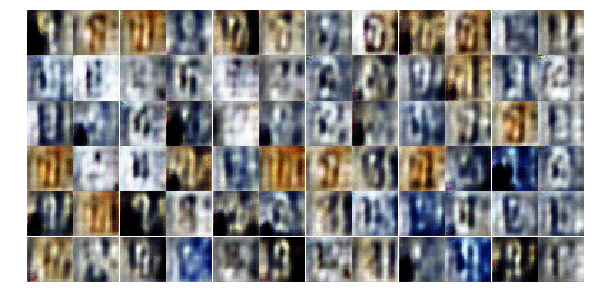

Epoch 3/5... Discriminator Loss: 0.4172... Generator Loss: 4.1436
Epoch 3/5... Discriminator Loss: 0.8867... Generator Loss: 1.3926
Epoch 3/5... Discriminator Loss: 0.7612... Generator Loss: 1.2015
Epoch 3/5... Discriminator Loss: 1.1393... Generator Loss: 4.2326
Epoch 3/5... Discriminator Loss: 0.6317... Generator Loss: 1.3369
Epoch 3/5... Discriminator Loss: 1.3402... Generator Loss: 0.6076
Epoch 3/5... Discriminator Loss: 1.1270... Generator Loss: 0.7295
Epoch 3/5... Discriminator Loss: 0.8680... Generator Loss: 1.5321
Epoch 3/5... Discriminator Loss: 0.6088... Generator Loss: 1.6355
Epoch 3/5... Discriminator Loss: 1.0670... Generator Loss: 0.6935


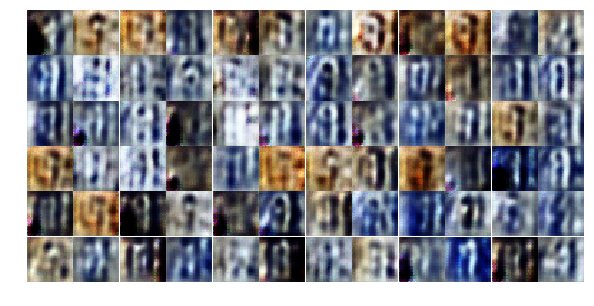

Epoch 3/5... Discriminator Loss: 0.7559... Generator Loss: 1.3743
Epoch 3/5... Discriminator Loss: 0.7197... Generator Loss: 2.7051
Epoch 3/5... Discriminator Loss: 0.7530... Generator Loss: 1.1001
Epoch 3/5... Discriminator Loss: 1.4364... Generator Loss: 0.4184
Epoch 3/5... Discriminator Loss: 0.9762... Generator Loss: 1.9331
Epoch 3/5... Discriminator Loss: 0.9178... Generator Loss: 2.4479
Epoch 3/5... Discriminator Loss: 0.7790... Generator Loss: 1.2879
Epoch 3/5... Discriminator Loss: 0.8056... Generator Loss: 1.2245
Epoch 3/5... Discriminator Loss: 0.5573... Generator Loss: 1.4480
Epoch 3/5... Discriminator Loss: 0.7292... Generator Loss: 1.0710


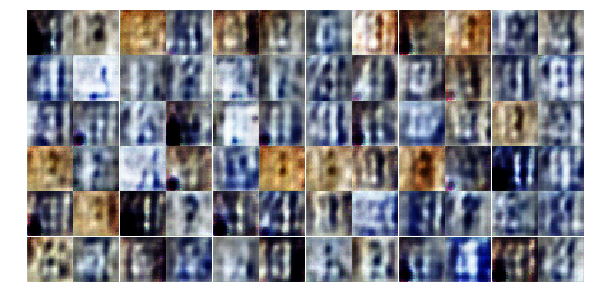

Epoch 3/5... Discriminator Loss: 0.6264... Generator Loss: 2.1738
Epoch 3/5... Discriminator Loss: 0.7567... Generator Loss: 1.0965
Epoch 3/5... Discriminator Loss: 0.9428... Generator Loss: 1.9698
Epoch 3/5... Discriminator Loss: 0.5257... Generator Loss: 1.6583
Epoch 3/5... Discriminator Loss: 0.4308... Generator Loss: 2.4844
Epoch 3/5... Discriminator Loss: 1.1298... Generator Loss: 0.5731
Epoch 3/5... Discriminator Loss: 1.0958... Generator Loss: 1.2357
Epoch 3/5... Discriminator Loss: 1.0110... Generator Loss: 0.7573
Epoch 3/5... Discriminator Loss: 1.0731... Generator Loss: 1.6842
Epoch 3/5... Discriminator Loss: 0.8936... Generator Loss: 1.4134


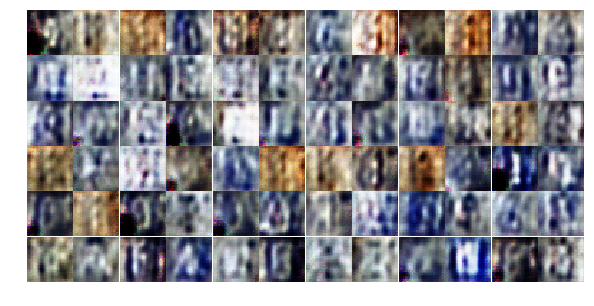

Epoch 3/5... Discriminator Loss: 1.0131... Generator Loss: 0.8198
Epoch 3/5... Discriminator Loss: 0.7387... Generator Loss: 1.4199


KeyboardInterrupt: 

In [49]:
# Load the data and train the network here
dataset = Dataset(trainset, testset)
losses, samples = train(net, dataset, epochs, batch_size, figsize=(10,5))

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [ ]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))